<a href="https://colab.research.google.com/github/abigailvania99/deepLearning/blob/main/Another_copy_of_BISNDO_2_Yet_another_copy_of_Final_BISINDO_VGG_dan_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Mengambil data dari Google Drive

###Menghubungkan ke Google Drive <br>
cara menghubungkan dengan melakukan mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Mengambil data dari Google Drive<br>
Mengambil data dari <br>
'/content/drive/MyDrive/Colab Notebooks/Citra BISINDO'

In [ ]:
import pathlib
data_path = '/content/drive/MyDrive/Colab Notebooks/Citra BISINDO(2)'
dataset_path = pathlib.Path(data_path)

##Melakukan Import

In [ ]:
import os
import pandas as pd
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16, DenseNet121
from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

##Membuat DataFrame <br>
Dataframe dibuat dengan menggunakan list 'images' yang berisi path dari gambar dan 'labels' yang berisi dari nama subfolder pada gambar

In [ ]:
images = []
labels = []


for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue


    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)

        images.append(image_path)
        labels.append(subfolder)

df = pd.DataFrame({'image': images, 'label': labels})

In [ ]:
df.head()

image label
0  /content/drive/MyDrive/Colab Notebooks/Citra B...     G
1  /content/drive/MyDrive/Colab Notebooks/Citra B...     G
2  /content/drive/MyDrive/Colab Notebooks/Citra B...     G
3  /content/drive/MyDrive/Colab Notebooks/Citra B...     G
4  /content/drive/MyDrive/Colab Notebooks/Citra B...     G

##Melakukan EDA

###Jumlah class klasifikasi

In [ ]:
len(df['label'].unique())

26

###Menampilkan sample dataset

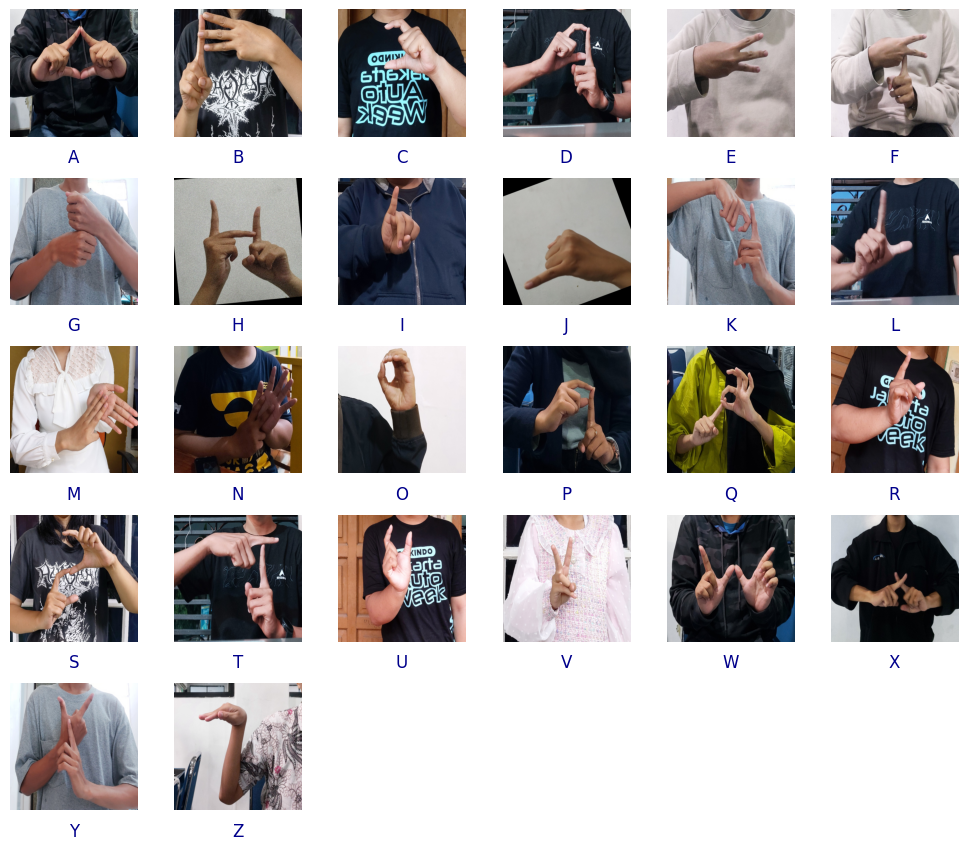

In [ ]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(6, 6, figure=fig)

for i, category in enumerate(sorted(df['label'].unique())):
    filepaths = df[df['label'] == category]['image'][:1]
    ax = fig.add_subplot(gs[int(i/6), i%6])
    ax.imshow(plt.imread(filepaths.iloc[0]))
    ax.axis('off')

    ax.text(0.5, -0.2, category, fontsize=12, color='darkblue', ha='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

###Menampilkan jumlah data pada masing-masing class

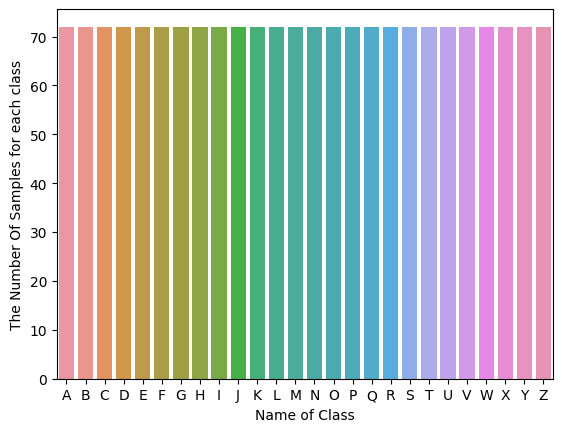

In [ ]:
ax = sns.countplot(x=sorted(df.label))

ax.set_xlabel("Name of Class")
ax.set_ylabel("The Number Of Samples for each class")

plt.xticks(rotation=0)
plt.show()

##Memisahkan data train, validation dan testing<br>
data training 60% <br>
data validation 20% <br>
data testing 20% <br>
Kemudian melakukan stratify untuk memastikan bahwa distribusi class dalam dataset tetap seimbang. Dan menggunakan random state 42

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(df['image'], df['label'], test_size=0.4, stratify=df['label'], random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, stratify= y_temp, random_state=42)


df_train = pd.DataFrame({'image': X_train, 'label': y_train})

df_val = pd.DataFrame({'image': X_val, 'label': y_val})

df_test = pd.DataFrame({'image': X_test, 'label': y_test})


##Melakukan Augmentasi gambar

Gambar dilakukan dengan cara meresize gambar menjadi 224, 224. <br>
Kemudian untuk data training, gambar dilakukan normalisasi terhadap nilai piksel gambar agar berada dalam rentang [0, 1]. Lalu melakukan Rotasi gambar dapat terjadi dalam rentang 0-45 derajat. Geser horizontal pada gambar dalam rentang 0-20% dari lebar gambar. Geser vertikal pada gambar dalam rentang 0-20% dari tinggi gambar. Memiringkan gambar dalam rentang 0-20%. Melakukan zoom pada gambar dalam rentang 0-20%. Melakukan flipping horizontal pada gambar.<br>
Sedangkan data testing dan validation hanya melakukan normalisasi terhadap nilai piksel gambar agar berada dalam rentang [0, 1].

In [ ]:
image_size = (224, 224)
batch_size = 128

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_test = ImageDataGenerator(
    rescale=1./255
)

##Melakukan Generator data dari DataFrames

In [ ]:

train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen_test.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen_test.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1123 validated image filenames belonging to 26 classes.
Found 375 validated image filenames belonging to 26 classes.
Found 374 validated image filenames belonging to 26 classes.


##Menentukan Earlystopping, Reduce learning rate dan menyimpan model terbaik

* Nilai yang dipantau adalah validation loss
* 10 epoch yang diizinkan tanpa peningkatan sebelum pelatihan dihentikan.
* Ketika sudah 5 epoch tidak mengalami peningkatan pembelajaran maka learning rate akan dikalikan 0.5
* Perubahan minimum 0.00001 pada validation loss yang dianggap sebagai perbaikan
* Model terbaik disimpan dengan menggunakan ModelCheckpoint dan mengecek setiap epoch

In [ ]:
earlystopping = EarlyStopping( monitor = 'val_loss',
                              min_delta = 0,
                               patience = 10,
                               verbose = 1,
                               restore_best_weights = True)

reducelr = ReduceLROnPlateau( monitor = 'val_loss',
                             factor = 0.5,
                              patience = 5,
                              verbose = 1,
                              min_delta = 0.00001)
path_model_vgg = '/content/drive/MyDrive/Colab Notebooks/copy_checkpoint_bisindo_VGG_copy_bisindo2(1).h5'
checkpoint_vgg = ModelCheckpoint (path_model_vgg,
                             verbose = 1,
                              save_best_only = True,
                              period = 1)

callback = [earlystopping, reducelr, checkpoint_vgg]

##VGG16

###Membangun Transfer Model VGG16

In [ ]:
input_shape = (*image_size, 3)
vgg = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)

model = Sequential()
model.add(vgg)
for layer in vgg.layers:
  layer.trainable = False

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(26, activation='softmax'))

58889256/58889256 [==============================] - 4s 0us/step


###Mengkonfigurasi Model
mengkonfigurasi model dengan menggunakan optimizer adam dan fungsi loss yang digunakan adalah categorical_crossentropy dan metrik evaluasinya adalah accuracy

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

###Melakukan Training sebanyak 50 epoch

In [ ]:
history1 = model.fit(train_generator,epochs=50,validation_data=val_generator, callbacks=[callback])

Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 7.7526 - accuracy: 0.0481  
Epoch 1: val_loss improved from inf to 4.52301, saving model to /content/drive/MyDrive/Colab Notebooks/copy_checkpoint_bisindo_VGG_copy_bisindo2(1).h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 995s 110s/step - loss: 7.7526 - accuracy: 0.0481 - val_loss: 4.5230 - val_accuracy: 0.1067 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 4.2640 - accuracy: 0.0864
Epoch 2: val_loss improved from 4.52301 to 2.90636, saving model to /content/drive/MyDrive/Colab Notebooks/copy_checkpoint_bisindo_VGG_copy_bisindo2(1).h5
9/9 [==============================] - 75s 9s/step - loss: 4.2640 - accuracy: 0.0864 - val_loss: 2.9064 - val_accuracy: 0.3013 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 2.9437 - accuracy: 0.1915
Epoch 3: val_loss improved from 2.90636 to 2.62348, saving model to /content/drive/MyDrive/Colab Notebooks/copy_checkpoint_bisindo_VGG_copy_bisindo2(1).h5
9/9 [==============================] - 73s 8s/step - loss: 2.9437 - accuracy: 0.1915 - val_loss: 2.6235 - val_accuracy: 0.3387 - lr: 0.0010
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 2.6958 - accuracy

###Melakukan evaluasi data testing dari 50 epoch pertama

In [ ]:
model_path = path_model_vgg
loaded_model = load_model(model_path)

metrics = loaded_model.evaluate(test_generator)
print('Accuracy:', metrics[1])

3/3 [==============================] - 195s 94s/step - loss: 0.6049 - accuracy: 0.8316
Accuracy: 0.8315507769584656


In [ ]:
best_epoch_1 = history1.epoch[history1.history['val_loss'].index(min(history1.history['val_loss']))]
print("Model terbaik pada epoch: ", best_epoch_1+1)

Model terbaik pada epoch:  48


###Melanjutkan proses training

In [ ]:
history2 = model.fit(train_generator, epochs=200, validation_data=val_generator, initial_epoch = 50, callbacks=[callback])

Epoch 51/200
9/9 [==============================] - ETA: 0s - loss: 0.5525 - accuracy: 0.8513
Epoch 51: val_loss improved from 0.57593 to 0.57164, saving model to /content/drive/MyDrive/Colab Notebooks/copy_checkpoint_bisindo_VGG_copy_bisindo2(1).h5
9/9 [==============================] - 72s 8s/step - loss: 0.5525 - accuracy: 0.8513 - val_loss: 0.5716 - val_accuracy: 0.8453 - lr: 5.0000e-04
Epoch 52/200
9/9 [==============================] - ETA: 0s - loss: 0.5524 - accuracy: 0.8584
Epoch 52: val_loss did not improve from 0.57164
9/9 [==============================] - 68s 8s/step - loss: 0.5524 - accuracy: 0.8584 - val_loss: 0.5757 - val_accuracy: 0.8480 - lr: 5.0000e-04
Epoch 53/200
9/9 [==============================] - ETA: 0s - loss: 0.5778 - accuracy: 0.8486
Epoch 53: val_loss improved from 0.57164 to 0.56217, saving model to /content/drive/MyDrive/Colab Notebooks/copy_checkpoint_bisindo_VGG_copy_bisindo2(1).h5
9/9 [==============================] - 68s 8s/step - loss: 0.5778 - ac

###Melakukan evaluasi data testing sampai maksimal 200 epoch

In [ ]:
model_path = path_model_vgg
loaded_model = load_model(model_path)

metrics = loaded_model.evaluate(test_generator)
print('Accuracy:', metrics[1])

3/3 [==============================] - 15s 5s/step - loss: 0.5460 - accuracy: 0.8556
Accuracy: 0.855614960193634


In [ ]:
best_epoch_2 = history2.epoch[history2.history['val_loss'].index(min(history2.history['val_loss']))]
print("Model terbaik pada epoch: ", best_epoch_2+1)

Model terbaik pada epoch:  71


###Menampilkan summary transfer model VGG16

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 26)                13338     
                                                                 
Total params: 27573594 (105.18 MB)
Trainable params: 12858906 (49.05 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


###Menampilkan gambar model VGG

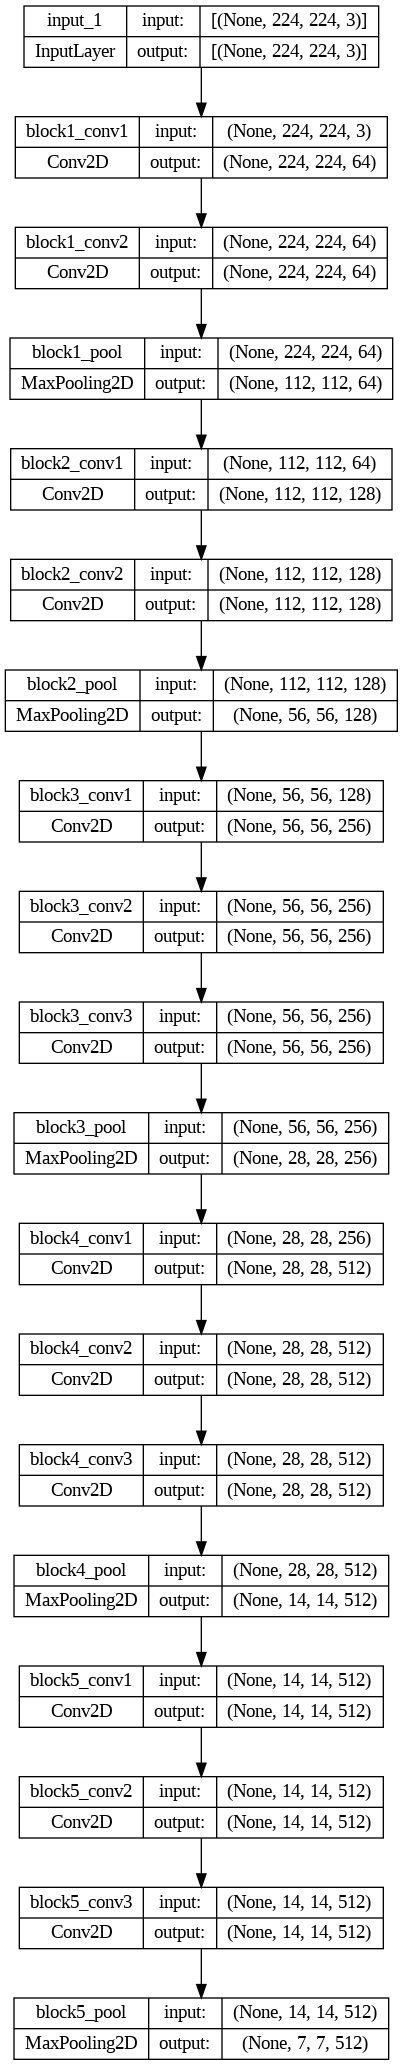

In [ ]:
plot_model(vgg, to_file='model_plot_vgg.png', show_shapes=True, show_layer_names=True)

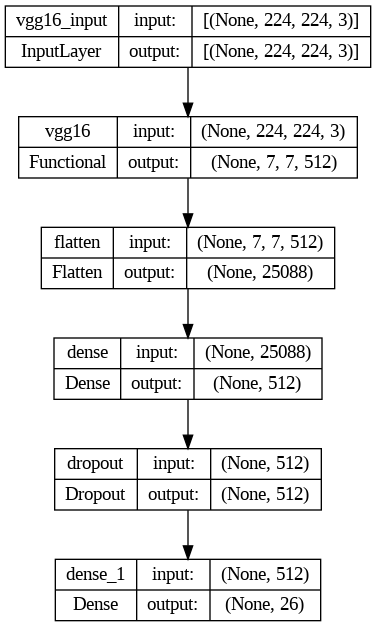

In [ ]:

plot_model(loaded_model, to_file='model_plot_vgg_transfer.png', show_shapes=True, show_layer_names=True)


###Evaluasi VGG

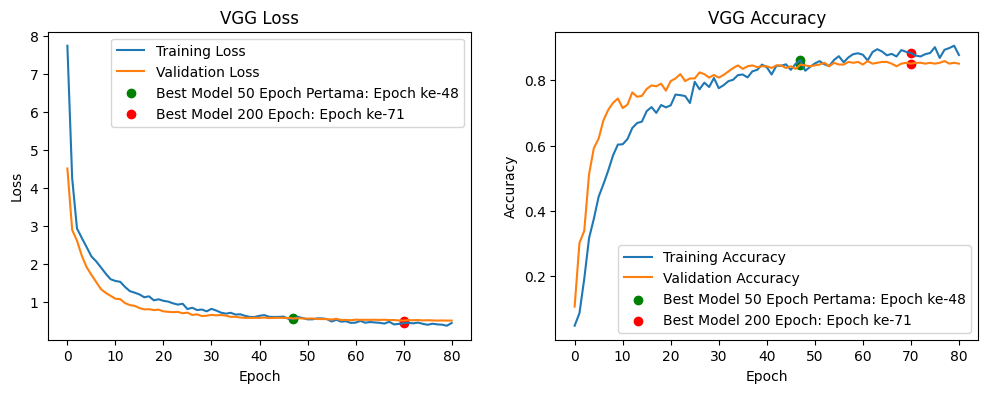

In [ ]:
import matplotlib.pyplot as plt
history_combined = {
    'loss': history1.history['loss'] + history2.history['loss'],
    'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
    'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy']
}

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_combined['loss'], label='Training Loss')
plt.plot(history_combined['val_loss'], label='Validation Loss')


epoch_loss_1 = history_combined['loss'][best_epoch_1]
epoch_val_loss_1 = history_combined['val_loss'][best_epoch_1]
epoch_loss_2 = history_combined['loss'][best_epoch_2]
epoch_val_loss_2 = history_combined['val_loss'][best_epoch_2]

plt.scatter(best_epoch_1, epoch_loss_1, color='green', marker='o', label=f'Best Model 50 Epoch Pertama: Epoch ke-{best_epoch_1+1}')
plt.scatter(best_epoch_1, epoch_val_loss_1, color='green', marker='o')

plt.scatter(best_epoch_2, epoch_loss_2, color='red', marker='o', label=f'Best Model 200 Epoch: Epoch ke-{best_epoch_2+1}')
plt.scatter(best_epoch_2, epoch_val_loss_2, color='red', marker='o')


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VGG Loss')
plt.legend()



plt.subplot(1, 2, 2)
plt.plot(history_combined['accuracy'], label='Training Accuracy')
plt.plot(history_combined['val_accuracy'], label='Validation Accuracy')

epoch_acc_1 = history_combined['accuracy'][best_epoch_1]
epoch_val_acc_1 = history_combined['val_accuracy'][best_epoch_1]

epoch_acc_2 = history_combined['accuracy'][best_epoch_2]
epoch_val_acc_2 = history_combined['val_accuracy'][best_epoch_2]

plt.scatter(best_epoch_1, epoch_acc_1, color='green', marker='o', label=f'Best Model 50 Epoch Pertama: Epoch ke-{best_epoch_1+1}')
plt.scatter(best_epoch_1, epoch_val_acc_1, color='green', marker='o')

plt.scatter(best_epoch_2, epoch_acc_2, color='red', marker='o', label=f'Best Model 200 Epoch: Epoch ke-{best_epoch_2+1}')
plt.scatter(best_epoch_2, epoch_val_acc_2, color='red', marker='o')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('VGG Accuracy')
plt.legend()
plt.show()


###Confusion Matrix VGG

3/3 [==============================] - 15s 5s/step


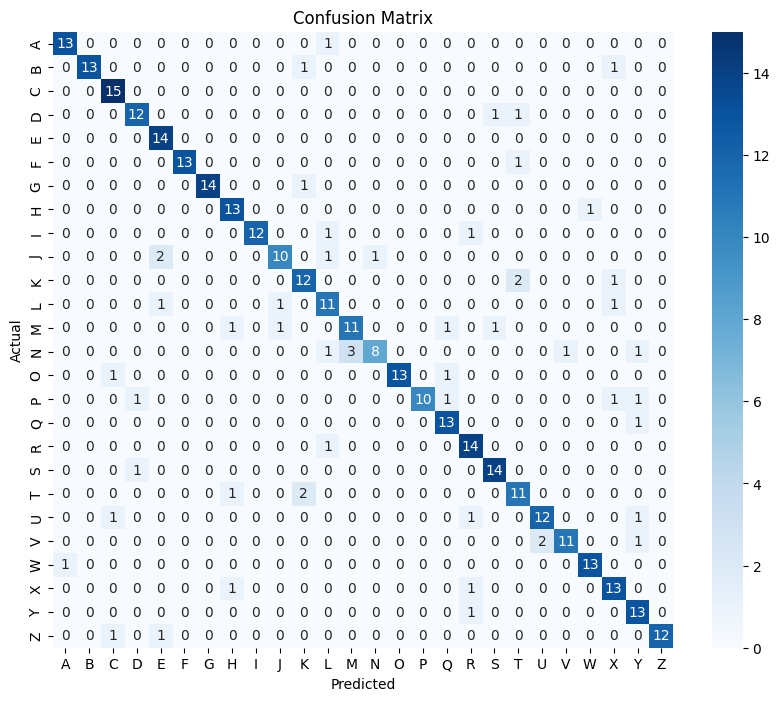

In [ ]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', yticklabels=test_generator.class_indices.keys(), xticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

###Classification Report VGG

In [ ]:
print(classification_report(test_generator.classes, y_pred_classes, target_names = train_generator.class_indices.keys()))


              precision    recall  f1-score   support

           A       0.93      0.93      0.93        14
           B       1.00      0.87      0.93        15
           C       0.83      1.00      0.91        15
           D       0.86      0.86      0.86        14
           E       0.78      1.00      0.88        14
           F       1.00      0.93      0.96        14
           G       1.00      0.93      0.97        15
           H       0.81      0.93      0.87        14
           I       1.00      0.86      0.92        14
           J       0.83      0.71      0.77        14
           K       0.75      0.80      0.77        15
           L       0.69      0.79      0.73        14
           M       0.79      0.73      0.76        15
           N       0.89      0.57      0.70        14
           O       1.00      0.87      0.93        15
           P       1.00      0.71      0.83        14
           Q       0.81      0.93      0.87        14
           R       0.78    

###Contoh Hasil Prediksi VGG

In [ ]:
print(f'Target:\n{test_generator.classes}')
print(f'Hasil Prediksi:\n{y_pred_classes}')

Target:
[8, 11, 6, 9, 9, 20, 2, 13, 20, 17, 6, 1, 10, 3, 18, 9, 10, 3, 12, 21, 22, 8, 10, 14, 6, 16, 21, 12, 15, 24, 4, 6, 11, 3, 1, 5, 12, 1, 11, 10, 15, 18, 7, 8, 8, 6, 6, 17, 7, 9, 22, 7, 13, 3, 20, 8, 12, 16, 18, 2, 14, 7, 25, 12, 19, 14, 12, 15, 18, 9, 8, 8, 23, 22, 5, 22, 16, 23, 5, 22, 18, 15, 15, 9, 21, 5, 13, 22, 7, 15, 14, 4, 13, 20, 3, 11, 13, 2, 8, 1, 14, 19, 0, 14, 17, 16, 20, 25, 5, 10, 10, 24, 0, 9, 13, 24, 18, 0, 3, 15, 23, 25, 16, 5, 6, 0, 13, 2, 14, 24, 6, 16, 19, 10, 1, 1, 19, 10, 25, 18, 13, 12, 9, 11, 24, 11, 19, 22, 9, 5, 14, 21, 25, 12, 22, 16, 2, 2, 9, 9, 3, 10, 19, 11, 4, 21, 22, 0, 22, 4, 1, 10, 2, 17, 14, 4, 4, 16, 24, 6, 11, 2, 23, 22, 11, 20, 13, 23, 13, 21, 25, 25, 4, 20, 4, 13, 0, 23, 1, 2, 23, 5, 1, 12, 23, 24, 21, 8, 21, 1, 15, 2, 1, 17, 25, 19, 0, 0, 7, 18, 12, 16, 23, 7, 9, 14, 22, 14, 1, 17, 0, 24, 22, 8, 17, 21, 12, 24, 7, 19, 18, 2, 17, 20, 18, 3, 25, 7, 6, 3, 25, 14, 8, 3, 25, 1, 5, 15, 23, 20, 3, 0, 16, 20, 25, 1, 11, 6, 0, 20, 8, 4, 11, 6, 10, 1

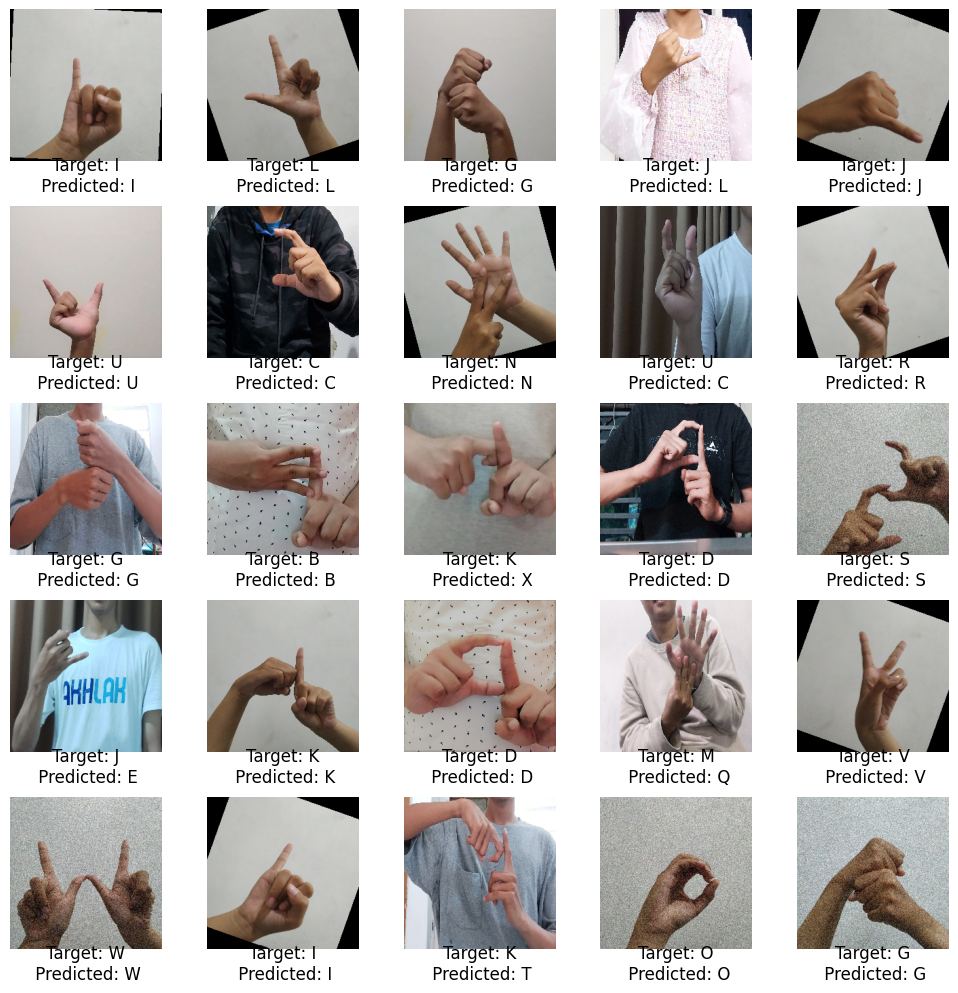

In [ ]:
batch_images, batch_labels = test_generator.next()

class_mapping = test_generator.class_indices

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(5, 5, figure=fig)

for i in range((25)):
    single_image = batch_images[i]
    single_label = batch_labels[i]

    ax = fig.add_subplot(gs[int(i/5), i%5])
    ax.imshow(single_image)

    true_class_label = list(class_mapping.keys())[list(class_mapping.values()).index(np.argmax(single_label))]
    predicted_class_label = list(class_mapping.keys())[list(class_mapping.values()).index(y_pred_classes[i])]

    ax.text(0.5, -0.2, f"Target: {true_class_label}\n Predicted: {predicted_class_label}",
            fontsize=12, color='black', ha='center', transform=ax.transAxes)
    ax.axis('off')



plt.tight_layout()
plt.show()

##DenseNet

###Membuat earlystopping, reduce learning rate dan menyimpan model dense

In [ ]:
path_model_dense = '/content/drive/MyDrive/Colab Notebooks/copy_checkpoint_bisindo_Dense_copy_bisindo2(1).h5'
checkpoint = ModelCheckpoint (path_model_dense,
                             verbose = 1,
                              save_best_only = True,
                              period = 1)

callback = [earlystopping, reducelr, checkpoint]

###Membangun Transfer Model DenseNet

In [ ]:
input_shape = (*image_size, 3)
dense = DenseNet121(input_shape=input_shape, weights='imagenet', include_top=False)

model_dense = Sequential()
model_dense.add(dense)
for layer in dense.layers:
  layer.trainable = False

model_dense.add(Flatten())
model_dense.add(Dense(512, activation='relu'))
model_dense.add(Dropout(0.1))
model_dense.add(Dense(26, activation='softmax'))

29084464/29084464 [==============================] - 2s 0us/step


###Mengkonfigurasi model

In [ ]:
model_dense.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

###Melakukan training model transfer learning dense

In [ ]:
history3 = model_dense.fit(train_generator,epochs=50,validation_data=val_generator, callbacks=[callback])

Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 27.1813 - accuracy: 0.0784
Epoch 1: val_loss improved from inf to 13.21813, saving model to /content/drive/MyDrive/Colab Notebooks/copy_checkpoint_bisindo_Dense_copy_bisindo2(1).h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 92s 9s/step - loss: 27.1813 - accuracy: 0.0784 - val_loss: 13.2181 - val_accuracy: 0.1733 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 9.9229 - accuracy: 0.1808 
Epoch 2: val_loss improved from 13.21813 to 2.83525, saving model to /content/drive/MyDrive/Colab Notebooks/copy_checkpoint_bisindo_Dense_copy_bisindo2(1).h5
9/9 [==============================] - 74s 9s/step - loss: 9.9229 - accuracy: 0.1808 - val_loss: 2.8353 - val_accuracy: 0.3787 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 3.0267 - accuracy: 0.2395
Epoch 3: val_loss improved from 2.83525 to 2.34070, saving model to /content/drive/MyDrive/Colab Notebooks/copy_checkpoint_bisindo_Dense_copy_bisindo2(1).h5
9/9 [==============================] - 75s 8s/step - loss: 3.0267 - accuracy: 0.2395 - val_loss: 2.3407 - val_accuracy: 0.3040 - lr: 0.0010
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 2.4786 - acc

###Melakukan evaluasi data testing dari 50 epoch pertama

In [ ]:

loaded_model_dense = load_model(path_model_dense)

metrics = loaded_model_dense.evaluate(test_generator)
print('Accuracy:', metrics[1])

3/3 [==============================] - 26s 9s/step - loss: 0.5525 - accuracy: 0.8476
Accuracy: 0.8475936055183411


In [ ]:
best_epoch_3 = history3.epoch[history3.history['val_loss'].index(min(history3.history['val_loss']))]
print("Model terbaik pada epoch: ", best_epoch_3+1)

Model terbaik pada epoch:  47


###Melanjutkan proses training

In [ ]:
history4 = model_dense.fit(train_generator,epochs=200,validation_data=val_generator, initial_epoch = 50, callbacks=[callback])

Epoch 51/200
9/9 [==============================] - ETA: 0s - loss: 0.3749 - accuracy: 0.8923
Epoch 51: val_loss did not improve from 0.54248
9/9 [==============================] - 75s 8s/step - loss: 0.3749 - accuracy: 0.8923 - val_loss: 0.5496 - val_accuracy: 0.8320 - lr: 2.5000e-04
Epoch 52/200
9/9 [==============================] - ETA: 0s - loss: 0.3931 - accuracy: 0.8842
Epoch 52: val_loss did not improve from 0.54248
9/9 [==============================] - 69s 8s/step - loss: 0.3931 - accuracy: 0.8842 - val_loss: 0.5434 - val_accuracy: 0.8427 - lr: 2.5000e-04
Epoch 53/200
9/9 [==============================] - ETA: 0s - loss: 0.4093 - accuracy: 0.8789
Epoch 53: val_loss improved from 0.54248 to 0.53882, saving model to /content/drive/MyDrive/Colab Notebooks/copy_checkpoint_bisindo_Dense_copy_bisindo2(1).h5
9/9 [==============================] - 74s 8s/step - loss: 0.4093 - accuracy: 0.8789 - val_loss: 0.5388 - val_accuracy: 0.8453 - lr: 2.5000e-04
Epoch 54/200
9/9 [==============

###Melakukan evaluasi data testing sampai maks 200 epoch

In [ ]:

loaded_model_dense = load_model(path_model_dense)

metrics = loaded_model_dense.evaluate(test_generator)
print('Accuracy:', metrics[1])

3/3 [==============================] - 17s 5s/step - loss: 0.5225 - accuracy: 0.8529
Accuracy: 0.8529411554336548


In [ ]:
best_epoch_4 = history4.epoch[history4.history['val_loss'].index(min(history4.history['val_loss']))]
print("Model terbaik pada epoch: ", best_epoch_4+1)

Model terbaik pada epoch:  80


###Menampilkan summary transfer model DenseNet121

In [ ]:
dense.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

In [ ]:
loaded_model_dense.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               25690624  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 26)                13338     
                                                                 
Total params: 32741466 (124.90 MB)
Trainable params: 25703962 (98.05 MB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


###Menampilkan gambar model DenseNet

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.693966 to fit



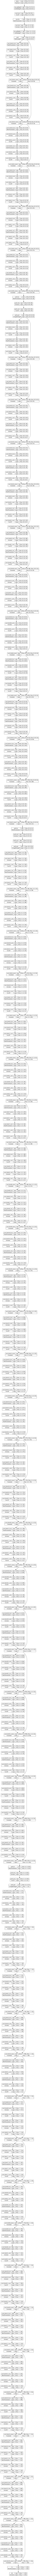

In [ ]:
plot_model(dense, to_file='model_plot_dense.png', show_shapes=True, show_layer_names=True)

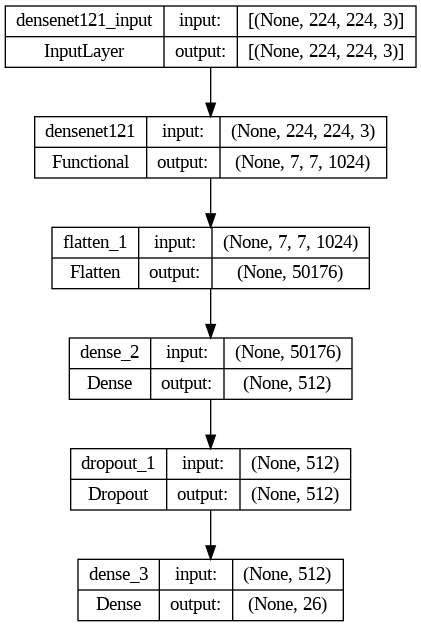

In [ ]:
plot_model(loaded_model_dense, to_file='model_plot_dense_transfer.png', show_shapes=True, show_layer_names=True)

###Evaluasi DenseNet121

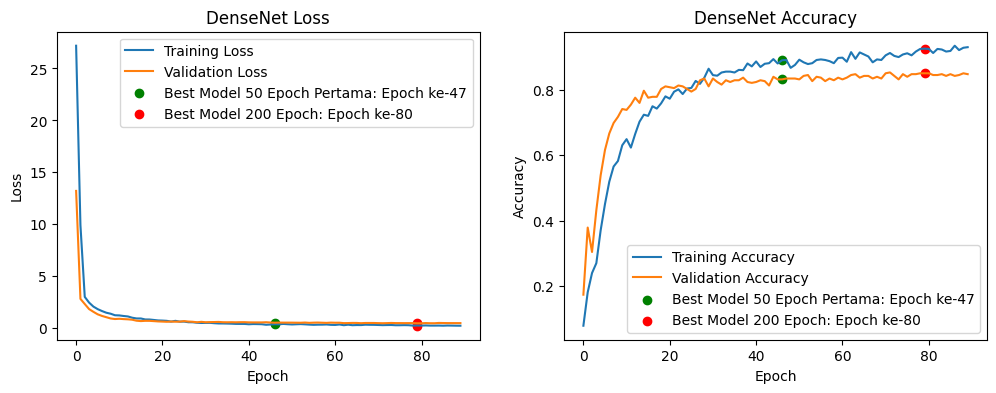

In [ ]:
history_combined1 = {
    'loss': history3.history['loss'] + history4.history['loss'],
    'accuracy': history3.history['accuracy'] + history4.history['accuracy'],
    'val_loss': history3.history['val_loss'] + history4.history['val_loss'],
    'val_accuracy': history3.history['val_accuracy'] + history4.history['val_accuracy']
}
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_combined1['loss'], label='Training Loss')
plt.plot(history_combined1['val_loss'], label='Validation Loss')


epoch_loss_3 = history_combined1['loss'][best_epoch_3]
epoch_val_loss_3 = history_combined1['val_loss'][best_epoch_3]
epoch_loss_4 = history_combined1['loss'][best_epoch_4]
epoch_val_loss_4 = history_combined1['val_loss'][best_epoch_4]

plt.scatter(best_epoch_3, epoch_loss_3, color='green', marker='o', label=f'Best Model 50 Epoch Pertama: Epoch ke-{best_epoch_3+1}')
plt.scatter(best_epoch_3, epoch_val_loss_3, color='green', marker='o')

plt.scatter(best_epoch_4, epoch_loss_4, color='red', marker='o', label=f'Best Model 200 Epoch: Epoch ke-{best_epoch_4+1}')
plt.scatter(best_epoch_4, epoch_val_loss_4, color='red', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DenseNet Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history_combined1['accuracy'], label='Training Accuracy')
plt.plot(history_combined1['val_accuracy'], label='Validation Accuracy')

epoch_acc_3 = history_combined1['accuracy'][best_epoch_3]
epoch_val_acc_3 = history_combined1['val_accuracy'][best_epoch_3]

epoch_acc_4 = history_combined1['accuracy'][best_epoch_4]
epoch_val_acc_4 = history_combined1['val_accuracy'][best_epoch_4]

plt.scatter(best_epoch_3, epoch_acc_3, color='green', marker='o', label=f'Best Model 50 Epoch Pertama: Epoch ke-{best_epoch_3+1}')
plt.scatter(best_epoch_3, epoch_val_acc_3, color='green', marker='o')

plt.scatter(best_epoch_4, epoch_acc_4, color='red', marker='o', label=f'Best Model 200 Epoch: Epoch ke-{best_epoch_4+1}')
plt.scatter(best_epoch_4, epoch_val_acc_4, color='red', marker='o')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('DenseNet Accuracy')
plt.legend()
plt.show()




###Confusion Matrix DenseNet

3/3 [==============================] - 17s 5s/step


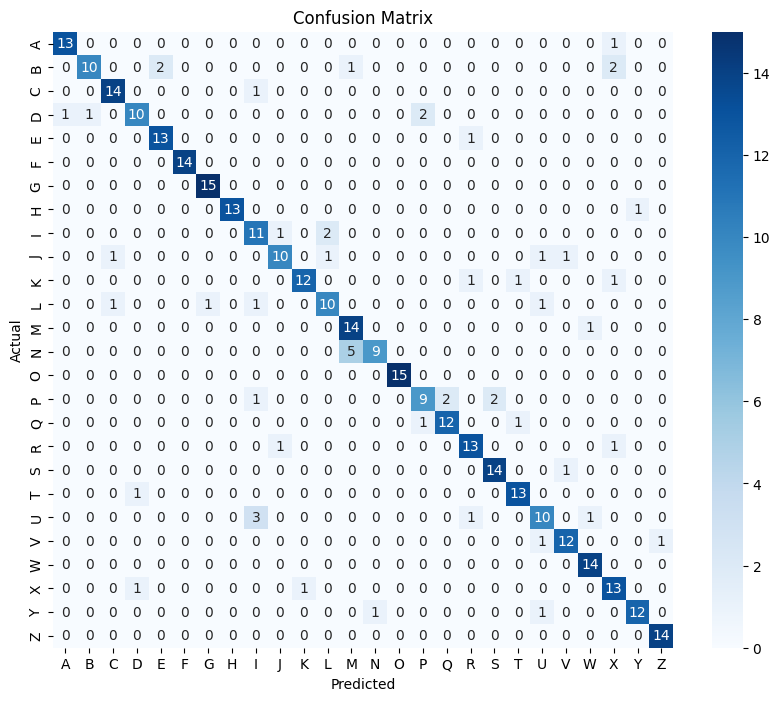

In [ ]:
y_pred_dense = model_dense.predict(test_generator)
y_pred_classes_dense = np.argmax(y_pred_dense, axis=1)

cm_dense = confusion_matrix(test_generator.classes, y_pred_classes_dense)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_dense, annot=True, fmt='d', cmap='Blues', yticklabels=test_generator.class_indices.keys(), xticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

###Classification Report DenseNet

In [ ]:
print(classification_report(test_generator.classes, y_pred_classes_dense, target_names = train_generator.class_indices.keys()))


              precision    recall  f1-score   support

           A       0.93      0.93      0.93        14
           B       0.91      0.67      0.77        15
           C       0.88      0.93      0.90        15
           D       0.83      0.71      0.77        14
           E       0.87      0.93      0.90        14
           F       1.00      1.00      1.00        14
           G       0.94      1.00      0.97        15
           H       1.00      0.93      0.96        14
           I       0.65      0.79      0.71        14
           J       0.83      0.71      0.77        14
           K       0.92      0.80      0.86        15
           L       0.77      0.71      0.74        14
           M       0.70      0.93      0.80        15
           N       0.90      0.64      0.75        14
           O       1.00      1.00      1.00        15
           P       0.75      0.64      0.69        14
           Q       0.86      0.86      0.86        14
           R       0.81    

###Hasil Prediksi DenseNet

In [ ]:
print(f'Target:\n{test_generator.classes}')
print(f'Hasil Prediksi:\n{y_pred_classes_dense}')

Target:
[8, 11, 6, 9, 9, 20, 2, 13, 20, 17, 6, 1, 10, 3, 18, 9, 10, 3, 12, 21, 22, 8, 10, 14, 6, 16, 21, 12, 15, 24, 4, 6, 11, 3, 1, 5, 12, 1, 11, 10, 15, 18, 7, 8, 8, 6, 6, 17, 7, 9, 22, 7, 13, 3, 20, 8, 12, 16, 18, 2, 14, 7, 25, 12, 19, 14, 12, 15, 18, 9, 8, 8, 23, 22, 5, 22, 16, 23, 5, 22, 18, 15, 15, 9, 21, 5, 13, 22, 7, 15, 14, 4, 13, 20, 3, 11, 13, 2, 8, 1, 14, 19, 0, 14, 17, 16, 20, 25, 5, 10, 10, 24, 0, 9, 13, 24, 18, 0, 3, 15, 23, 25, 16, 5, 6, 0, 13, 2, 14, 24, 6, 16, 19, 10, 1, 1, 19, 10, 25, 18, 13, 12, 9, 11, 24, 11, 19, 22, 9, 5, 14, 21, 25, 12, 22, 16, 2, 2, 9, 9, 3, 10, 19, 11, 4, 21, 22, 0, 22, 4, 1, 10, 2, 17, 14, 4, 4, 16, 24, 6, 11, 2, 23, 22, 11, 20, 13, 23, 13, 21, 25, 25, 4, 20, 4, 13, 0, 23, 1, 2, 23, 5, 1, 12, 23, 24, 21, 8, 21, 1, 15, 2, 1, 17, 25, 19, 0, 0, 7, 18, 12, 16, 23, 7, 9, 14, 22, 14, 1, 17, 0, 24, 22, 8, 17, 21, 12, 24, 7, 19, 18, 2, 17, 20, 18, 3, 25, 7, 6, 3, 25, 14, 8, 3, 25, 1, 5, 15, 23, 20, 3, 0, 16, 20, 25, 1, 11, 6, 0, 20, 8, 4, 11, 6, 10, 1

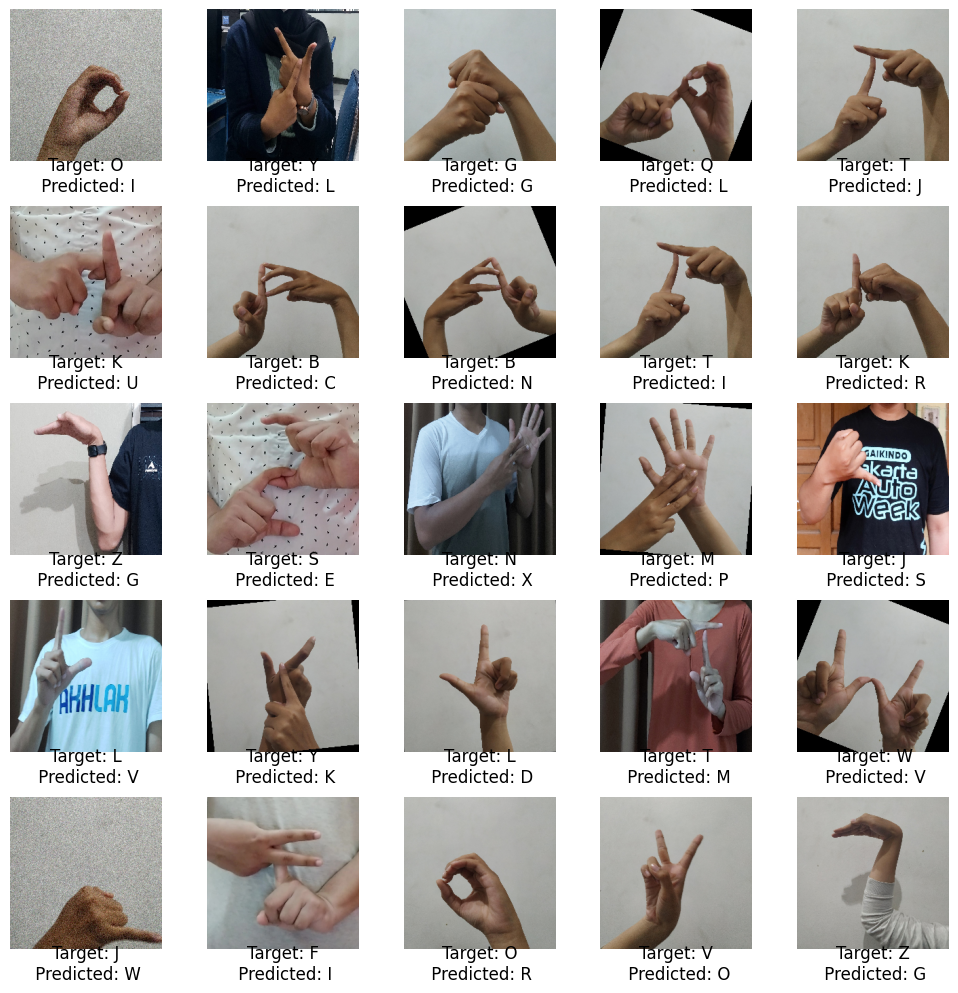

In [ ]:
batch_images, batch_labels = test_generator.next()

class_mapping = test_generator.class_indices

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(5, 5, figure=fig)

for i in range((25)):
    single_image = batch_images[i]
    single_label = batch_labels[i]

    ax = fig.add_subplot(gs[int(i/5), i%5])
    ax.imshow(single_image)

    true_class_label = list(class_mapping.keys())[list(class_mapping.values()).index(np.argmax(single_label))]
    predicted_class_label_dense = list(class_mapping.keys())[list(class_mapping.values()).index(y_pred_classes_dense[i])]

    ax.text(0.5, -0.2, f"Target: {true_class_label}\n Predicted: {predicted_class_label_dense}",
            fontsize=12, color='black', ha='center', transform=ax.transAxes)
    ax.axis('off')



plt.tight_layout()
plt.show()

##Perbandingan VGG16 dan DenseNet121

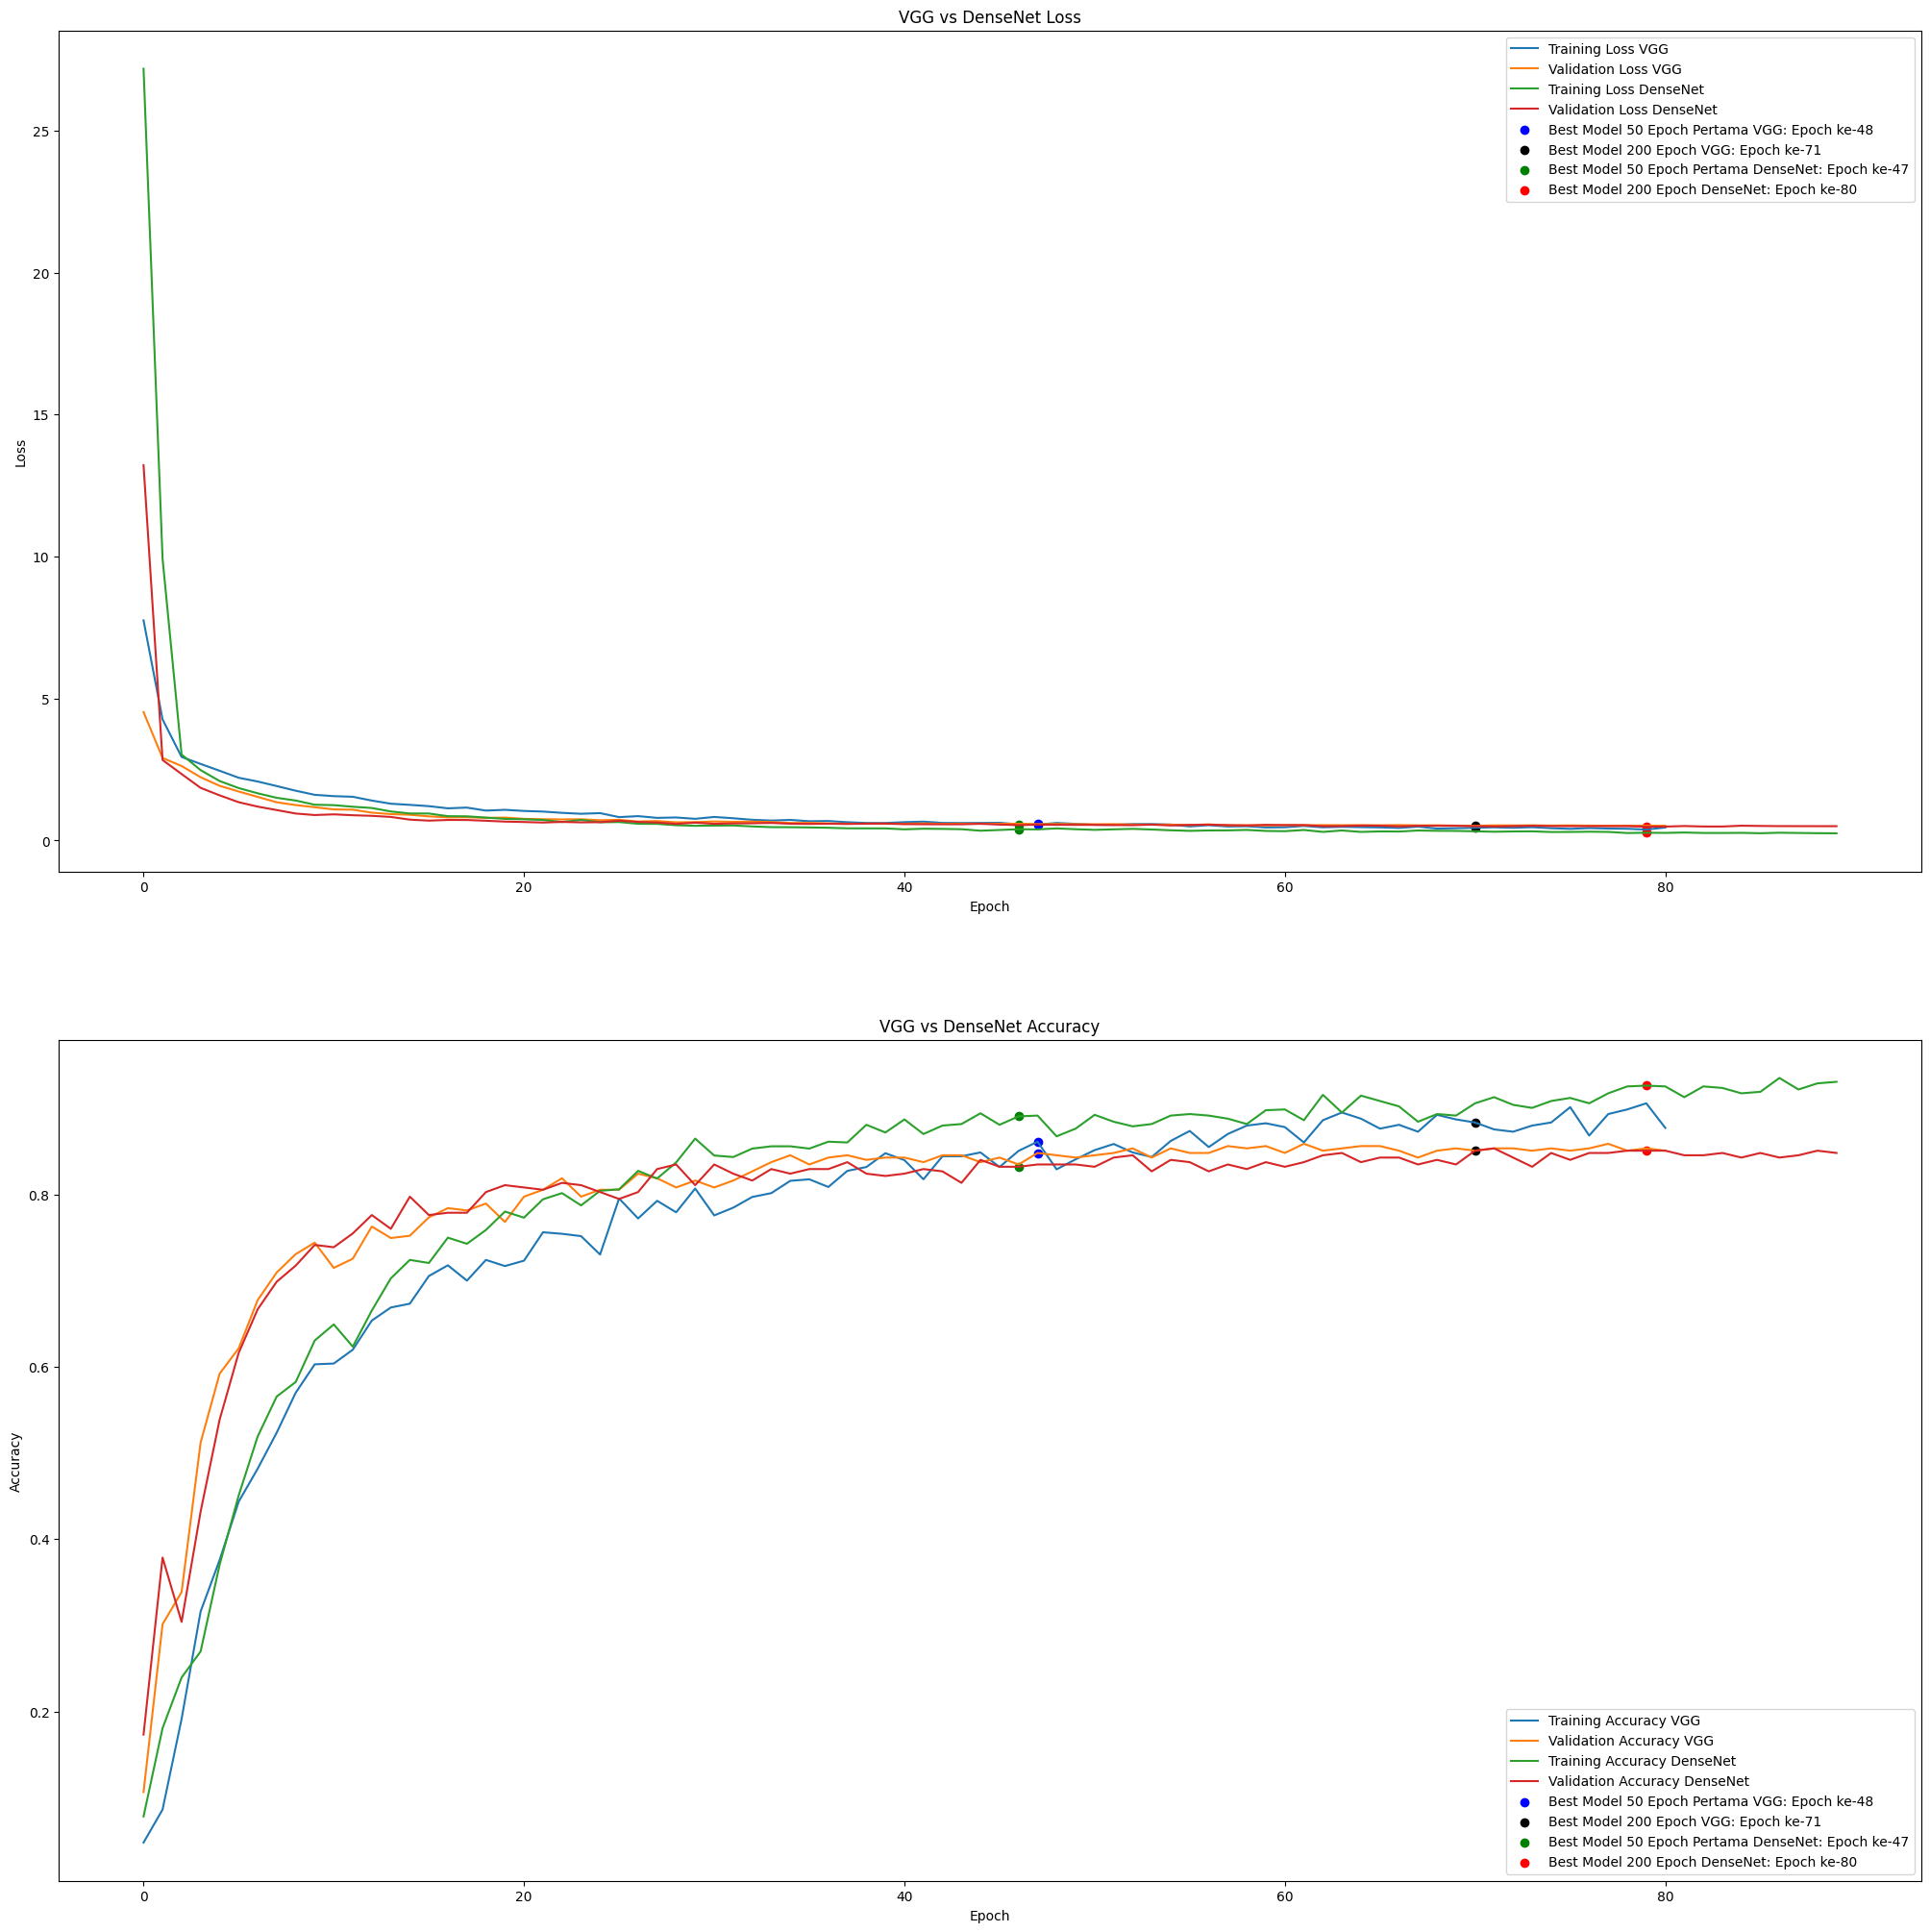

In [ ]:
plt.figure(figsize=(25, 25))

plt.subplot(2, 1, 1)
plt.plot(history_combined['loss'], label='Training Loss VGG')
plt.plot(history_combined['val_loss'], label='Validation Loss VGG')
plt.plot(history_combined1['loss'], label='Training Loss DenseNet')
plt.plot(history_combined1['val_loss'], label='Validation Loss DenseNet')

plt.scatter(best_epoch_1, epoch_loss_1, color='blue', marker='o', label=f'Best Model 50 Epoch Pertama VGG: Epoch ke-{best_epoch_1+1}')
plt.scatter(best_epoch_1, epoch_val_loss_1, color='blue', marker='o')

plt.scatter(best_epoch_2, epoch_loss_2, color='black', marker='o', label=f'Best Model 200 Epoch VGG: Epoch ke-{best_epoch_2+1}')
plt.scatter(best_epoch_2, epoch_val_loss_2, color='black', marker='o')

plt.scatter(best_epoch_3, epoch_loss_3, color='green', marker='o', label=f'Best Model 50 Epoch Pertama DenseNet: Epoch ke-{best_epoch_3+1}')
plt.scatter(best_epoch_3, epoch_val_loss_3, color='green', marker='o')

plt.scatter(best_epoch_4, epoch_loss_4, color='red', marker='o', label=f'Best Model 200 Epoch DenseNet: Epoch ke-{best_epoch_4+1}')
plt.scatter(best_epoch_4, epoch_val_loss_4, color='red', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VGG vs DenseNet Loss')
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(history_combined['accuracy'], label='Training Accuracy VGG')
plt.plot(history_combined['val_accuracy'], label='Validation Accuracy VGG')
plt.plot(history_combined1['accuracy'], label='Training Accuracy DenseNet')
plt.plot(history_combined1['val_accuracy'], label='Validation Accuracy DenseNet')

plt.scatter(best_epoch_1, epoch_acc_1, color='blue', marker='o', label=f'Best Model 50 Epoch Pertama VGG: Epoch ke-{best_epoch_1+1}')
plt.scatter(best_epoch_1, epoch_val_acc_1, color='blue', marker='o')

plt.scatter(best_epoch_2, epoch_acc_2, color='black', marker='o', label=f'Best Model 200 Epoch VGG: Epoch ke-{best_epoch_2+1}')
plt.scatter(best_epoch_2, epoch_val_acc_2, color='black', marker='o')


plt.scatter(best_epoch_3, epoch_acc_3, color='green', marker='o', label=f'Best Model 50 Epoch Pertama DenseNet: Epoch ke-{best_epoch_3+1}')
plt.scatter(best_epoch_3, epoch_val_acc_3, color='green', marker='o')

plt.scatter(best_epoch_4, epoch_acc_4, color='red', marker='o', label=f'Best Model 200 Epoch DenseNet: Epoch ke-{best_epoch_4+1}')
plt.scatter(best_epoch_4, epoch_val_acc_4, color='red', marker='o')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('VGG vs DenseNet Accuracy')
plt.legend()
plt.show()